<a href="https://colab.research.google.com/github/skywalker0803r/telegram-investment-advice-bot/blob/main/backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 套件

In [10]:
#!pip install yfinance
#!pip install finta

[*********************100%***********************]  1 of 1 completed


100%|██████████| 1197/1197 [00:01<00:00, 1094.50it/s]


38/38 [==============================] - 1s 15ms/step


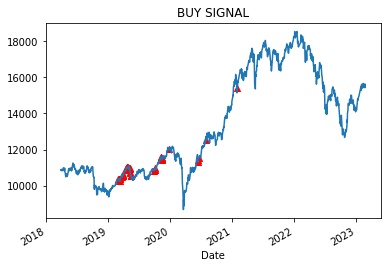

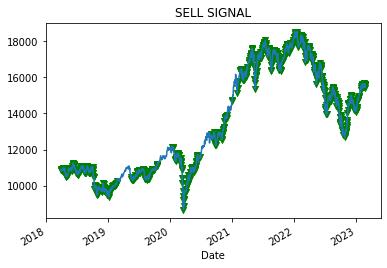

買入時間: 2018-11-30 00:00:00
買入價格: 9888.0302734375
賣出時間: 2018-12-25 00:00:00
賣出價格: 9527.08984375
獲利: -36454.9833984375
買入時間: 2018-12-26 00:00:00
買入價格: 9478.990234375
賣出時間: 2019-01-15 00:00:00
賣出價格: 9806.0400390625
獲利: 33032.0302734375
買入時間: 2019-01-16 00:00:00
買入價格: 9763.8095703125
賣出時間: 2019-02-12 00:00:00
賣出價格: 10097.740234375
獲利: 34060.927734375
買入時間: 2019-02-13 00:00:00
買入價格: 10090.580078125
賣出時間: 2019-02-22 00:00:00
賣出價格: 10322.919921875
獲利: 23698.6640625
買入時間: 2019-07-10 00:00:00
買入價格: 10798.48046875
賣出時間: 2019-07-22 00:00:00
賣出價格: 10944.5302734375
獲利: 14166.8310546875
買入時間: 2019-08-16 00:00:00
買入價格: 10420.8896484375
賣出時間: 2019-09-05 00:00:00
賣出價格: 10756.9296875
獲利: 34276.083984375
買入時間: 2019-10-08 00:00:00
買入價格: 11017.3095703125
賣出時間: 2019-10-28 00:00:00
賣出價格: 11315.01953125
獲利: 29770.99609375
買入時間: 2020-03-25 00:00:00
買入價格: 9644.75
賣出時間: 2020-03-30 00:00:00
賣出價格: 9629.4296875
獲利: -1792.4765625
買入時間: 2020-05-12 00:00:00
買入價格: 10879.4697265625
賣出時間: 2020-06-03 00:00:00
賣出價格: 11320.1

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from finta import TA
from tqdm import tqdm

# 下載台灣加權指數資料
ticker = '^TWII'
start_date = '2018-01-01'#從訓練資料沒有包括的時間開始做回測
end_date = '2023-02-26'#設置回測結束日期
df = yf.download(ticker, start=start_date, end=end_date)

# 載入Model和Scaler
model = load_model('model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 此函數參考至CHATGPT:https://sharegpt.com/c/CTyoQQ2
def calculate_ta(df):
    ta_functions = [TA.RSI, TA.WILLIAMS, TA.SMA, TA.EMA, TA.WMA, TA.HMA, TA.TEMA, TA.CCI, TA.CMO, TA.MACD, TA.PPO, TA.ROC, TA.CFI, TA.DMI, TA.SAR]
    ta_names = ['RSI', 'Williams %R', 'SMA', 'EMA', 'WMA', 'HMA', 'TEMA', 'CCI', 'CMO', 'MACD', 'PPO', 'ROC', 'CFI', 'DMI', 'SAR']
    for i, ta_func in enumerate(ta_functions):
        try:
            df[ta_names[i]] = ta_func(df)
        except:
            if ta_names[i] == 'MACD':
                df[ta_names[i]] = ta_func(df)['MACD']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'PPO':
                df[ta_names[i]] = ta_func(df)['PPO']-ta_func(df)['SIGNAL']  
            if ta_names[i] == 'DMI':
                df[ta_names[i]] = ta_func(df)['DI+']-ta_func(df)['DI-']
    return df

# 輸入股價資料,scaler,model,輸出(0,1,2)等買進賣出訊號
def process(df,scaler,model):
    # 特徵工程
    df = calculate_ta(df)
    df = df.dropna(axis=0)
    features = df.columns[-15:].tolist()
    Close = df[['Close']]
    df = df[features]
    
    # 數值轉換
    df[features] = scaler.transform(df[features])
    
    # 製作X
    days = 15
    start_index = 0
    end_index = len(df)-days
    Xs = []
    indexs = []
    for i in tqdm(range(start_index ,end_index+1 ,1)):
        X = df.iloc[i:i+days,:][features]
        X = np.array(X)
        Xs.append(X)
        indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index))
    Xs = np.array(Xs)
    
    # 模型預測
    answer = model.predict(Xs)
    answer = [ np.argmax(i) for i in answer]
    
    # 繪製圖表
    Close = Close.iloc[-len(Xs):,:]
    Close['SIGNAL'] = answer
    buy = Close[Close['SIGNAL']==1]['Close']
    sell = Close[Close['SIGNAL']==2]['Close']
    Close['Close'].plot()
    plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
    plt.title('BUY SIGNAL')
    plt.show()
    Close['Close'].plot()
    plt.scatter(list(sell.index),list(sell.values),color='green',marker='v')
    plt.title('SELL SIGNAL')
    plt.show()
    
    return answer

signals = process(df,scaler,model)

# 回測框架參考自CHATGPT
# https://shareg.pt/wQwSsaA
capital = 1000000  # 初始資本
hold = False  # 是否持有股票
entry_price = 0  # 進場價格
entry_idx = 0  # 進場時間點
exit_price = 0  # 出場價格
exit_idx = 0  # 出場時間點
t = 20
lb = 0.97
ub = 1.03
capital_history = []
for i, signal in enumerate(signals):
    if signal == 1 and not hold:  # 進場買入
        hold = True
        entry_price = df.iloc[i]['Close']
        entry_idx = i
    elif signal == 2 and hold:  # 出場賣出
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
        print('買入時間:', df.index[entry_idx])
        print('買入價格:', entry_price)
        print('賣出時間:', df.index[exit_idx])
        print('賣出價格:', exit_price)
        print('獲利:', profit)
    elif hold and (i - entry_idx >= t or df.iloc[i]['Close'] <= entry_price * lb or df.iloc[i]['Close'] >= entry_price * ub):  # 到達出場條件
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
        print('買入時間:', df.index[entry_idx])
        print('買入價格:', entry_price)
        print('賣出時間:', df.index[exit_idx])
        print('賣出價格:', exit_price)
        print('獲利:', profit)
    capital_history.append(capital)


報酬率:+18.06855703125001%
最大回撤:-3.6454983398437446%


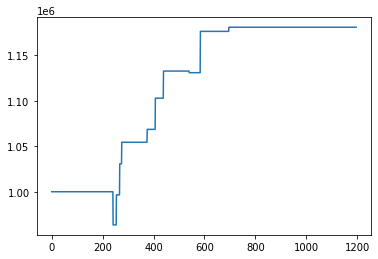

In [12]:
plt.plot(capital_history)
print(f"報酬率:+{(capital_history[-1]/capital_history[0]-1)*100}%")
print(f"最大回撤:{-(1-min(capital_history)/capital_history[0])*100}%")